# Plots with confidence interval

In [164]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import json
import numpy as np
from scipy.stats import t as student_variable

parameters = json.load(open("parameters.json"))

max_bellman_iterations = 4
max_bellman_iterations_validation = max_bellman_iterations + 5
n_seeds = 10
n_samples = parameters["n_discrete_states"] * parameters["n_discrete_actions"]
n_weights = parameters["n_weights"]
initial_std = parameters["initial_std"]
q_weights_dimension = 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Compute confidence intervals

In [165]:
def single_confidence_interval(mean, std, n_samples, confidence_level):
    t_crit = np.abs(student_variable.ppf((1 - confidence_level) / 2, n_samples - 1))
    lower_bound = mean - t_crit * (std / np.sqrt(n_samples))
    upper_bound = mean + t_crit * (std / np.sqrt(n_samples))

    return lower_bound, upper_bound

def confidence_interval(means, stds, n_samples, confidence_level=0.95):
    confidence_intervals = np.zeros((2, len(means)))

    for idx_iteration in range(len(means)):
        confidence_intervals[0, idx_iteration], confidence_intervals[1, idx_iteration] = single_confidence_interval(means[idx_iteration], stds[idx_iteration], n_samples, confidence_level)

    return confidence_intervals

## General case

### Extract data

In [166]:
fqi_w = np.zeros((n_seeds, max_bellman_iterations + 1, q_weights_dimension))
fqi_pi = np.zeros((n_seeds, max_bellman_iterations + 1))

for idx_seed, seed in enumerate(range(1, n_seeds + 1)):
    fqi_w[idx_seed] = np.load(f"figures/data/FQI/{max_bellman_iterations}_W_{seed}.npy")
    fqi_pi[idx_seed] = np.load(f"figures/data/FQI/{max_bellman_iterations}_Pi_{seed}.npy")

lspi_w = np.zeros((n_seeds, max_bellman_iterations + 1, q_weights_dimension))
lspi_pi = np.zeros((n_seeds, max_bellman_iterations + 1))

for idx_seed, seed in enumerate(range(1, n_seeds + 1)):
    lspi_w[idx_seed] = np.load(f"figures/data/LSPI/{max_bellman_iterations}_W_{seed}.npy")
    lspi_pi[idx_seed] = np.load(f"figures/data/LSPI/{max_bellman_iterations}_Pi_{seed}.npy")

optimal_w = np.load(f"figures/data/optimal/W.npy")
optimal_pi = np.load(f"figures/data/optimal/Pi.npy")

pbo_linear_w = np.zeros((n_seeds, max_bellman_iterations_validation + 2, q_weights_dimension))
pbo_linear_pi = np.zeros((n_seeds, max_bellman_iterations_validation + 2))

for idx_seed, seed in enumerate(range(1, n_seeds + 1)):
    pbo_linear_w[idx_seed] = np.load(f"figures/data/PBO_linear/{max_bellman_iterations}_W_{initial_std}_{seed}.npy")
    pbo_linear_pi[idx_seed] = np.load(f"figures/data/PBO_linear/{max_bellman_iterations}_Pi_{initial_std}_{seed}.npy")

pbo_custom_linear_w = np.zeros((n_seeds, max_bellman_iterations_validation + 1, q_weights_dimension))
pbo_custom_linear_pi = np.zeros((n_seeds, max_bellman_iterations_validation + 1))

for idx_seed, seed in enumerate(range(1, n_seeds + 1)):
    pbo_custom_linear_w[idx_seed] = np.load(f"figures/data/PBO_custom_linear/{max_bellman_iterations}_W_{n_samples}_{seed}.npy")
    pbo_custom_linear_pi[idx_seed] = np.load(f"figures/data/PBO_custom_linear/{max_bellman_iterations}_Pi_{n_samples}_{seed}.npy")

pbo_optimal_w = np.load(f"figures/data/PBO_optimal/{max_bellman_iterations}_W.npy")
pbo_optimal_pi = np.load(f"figures/data/PBO_optimal/{max_bellman_iterations}_Pi.npy")

### Distances with the optimal weights

In [167]:
fqi_w_mean = np.sqrt(np.mean(np.square(fqi_w - optimal_w), axis=2)).mean(axis=0)
fqi_w_std = np.sqrt(np.mean(np.square(fqi_w - optimal_w), axis=2)).std(axis=0)
fqi_w_confidence_interval = confidence_interval(fqi_w_mean, fqi_w_std, n_seeds)

lspi_w_mean = np.sqrt(np.mean(np.square(lspi_w - optimal_w), axis=2)).mean(axis=0)
lspi_w_std = np.sqrt(np.mean(np.square(lspi_w - optimal_w), axis=2)).std(axis=0)
lspi_w_confidence_interval = confidence_interval(lspi_w_mean, lspi_w_std, n_seeds)

pbo_linear_w_mean = np.sqrt(np.mean(np.square(pbo_linear_w - optimal_w), axis=2)).mean(axis=0)
pbo_linear_w_std = np.sqrt(np.mean(np.square(pbo_linear_w - optimal_w), axis=2)).std(axis=0)
pbo_linear_w_confidence_interval = confidence_interval(pbo_linear_w_mean, pbo_linear_w_std, n_seeds)

pbo_custom_linear_w_mean = np.sqrt(np.mean(np.square(pbo_custom_linear_w - optimal_w), axis=2)).mean(axis=0)
pbo_custom_linear_w_std = np.sqrt(np.mean(np.square(pbo_custom_linear_w - optimal_w), axis=2)).std(axis=0)
pbo_custom_linear_w_confidence_interval = confidence_interval(pbo_custom_linear_w_mean, pbo_custom_linear_w_std, n_seeds)

pbo_optimal_w_mean = np.sqrt(np.mean(np.square(pbo_optimal_w - optimal_w), axis=1))

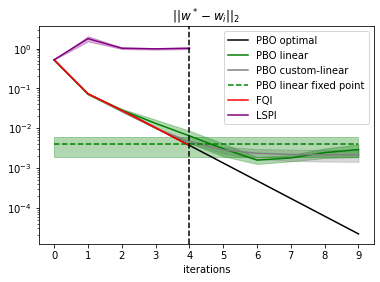

In [168]:
import matplotlib.pyplot as plt 

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)

plt.plot(iterations_validation, pbo_optimal_w_mean, label="PBO optimal", color="black")

plt.plot(iterations_validation, pbo_linear_w_mean[:-1], label="PBO linear", color="green")
plt.fill_between(iterations_validation, pbo_linear_w_confidence_interval[0, :-1], pbo_linear_w_confidence_interval[1, :-1], color="green", alpha=0.3)

plt.plot(iterations_validation, pbo_custom_linear_w_mean, label="PBO custom-linear", color="grey")
plt.fill_between(iterations_validation, pbo_custom_linear_w_confidence_interval[0], pbo_custom_linear_w_confidence_interval[1], color="grey", alpha=0.3)

plt.hlines(pbo_linear_w_mean[-1], 0, max_bellman_iterations_validation, color="green", linestyle="--", label="PBO linear fixed point")
plt.fill_between(iterations_validation, pbo_linear_w_confidence_interval[0, -1], pbo_linear_w_confidence_interval[1, -1], color="green", alpha=0.3)

plt.plot(iterations, fqi_w_mean, label="FQI", color="red")
plt.fill_between(iterations, fqi_w_confidence_interval[0], fqi_w_confidence_interval[1], color="red", alpha=0.3)

plt.plot(iterations, lspi_w_mean, label="LSPI", color="purple")
plt.fill_between(iterations, lspi_w_confidence_interval[0], lspi_w_confidence_interval[1], color="purple", alpha=0.3)

plt.axvline(max_bellman_iterations, color="black", linestyle="--")
plt.xticks(iterations_validation)
plt.xlabel("iterations")
plt.yscale("log")
plt.title(r"$|| w^* - w_i ||_2$")
plt.legend()
_ = plt.savefig(f"figures/distance_to_optimal_W_{max_bellman_iterations}.jpg", bbox_inches='tight')

### Distance to optimal value function

In [169]:
fqi_pi_mean = np.abs(fqi_pi - optimal_pi).mean(axis=0)
fqi_pi_std = np.abs(fqi_pi - optimal_pi).std(axis=0)
fqi_pi_confidence_interval = confidence_interval(fqi_pi_mean, fqi_pi_std, n_seeds)

lspi_pi_mean = np.abs(lspi_pi - optimal_pi).mean(axis=0)
lspi_pi_std = np.abs(lspi_pi - optimal_pi).std(axis=0)
lspi_pi_confidence_interval = confidence_interval(lspi_pi_mean, lspi_pi_std, n_seeds)

pbo_linear_pi_mean = np.abs(pbo_linear_pi - optimal_pi).mean(axis=0)
pbo_linear_pi_std = np.abs(pbo_linear_pi - optimal_pi).std(axis=0)
pbo_linear_pi_confidence_interval = confidence_interval(pbo_linear_pi_mean, pbo_linear_pi_std, n_seeds)

pbo_custom_linear_pi_mean = np.abs(pbo_custom_linear_pi - optimal_pi).mean(axis=0)
pbo_custom_linear_pi_std = np.abs(pbo_custom_linear_pi - optimal_pi).std(axis=0)
pbo_custom_linear_pi_confidence_interval = confidence_interval(pbo_custom_linear_pi_mean, pbo_custom_linear_pi_std, n_seeds)

pbo_optimal_pi_mean = np.abs(pbo_optimal_pi - optimal_pi)

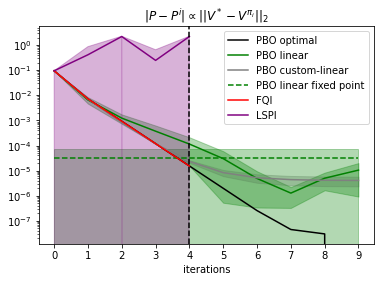

In [170]:
import matplotlib.pyplot as plt 

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)

plt.plot(iterations_validation, pbo_optimal_pi_mean, label="PBO optimal", color="black")

plt.plot(iterations_validation, pbo_linear_pi_mean[:-1], label="PBO linear", color="green")
plt.fill_between(iterations_validation, pbo_linear_pi_confidence_interval[0, :-1], pbo_linear_pi_confidence_interval[1, :-1], color="green", alpha=0.3)

plt.plot(iterations_validation, pbo_custom_linear_pi_mean, label="PBO custom-linear", color="grey")
plt.fill_between(iterations_validation, pbo_custom_linear_pi_confidence_interval[0], pbo_custom_linear_pi_confidence_interval[1], color="grey", alpha=0.3)

plt.hlines(pbo_linear_pi_mean[-1], 0, max_bellman_iterations_validation, color="green", linestyle="--", label="PBO linear fixed point")
plt.fill_between(iterations_validation, pbo_linear_pi_confidence_interval[0, -1], pbo_linear_pi_confidence_interval[1, -1], color="green", alpha=0.3)

plt.plot(iterations, fqi_pi_mean, label="FQI", color="red")
plt.fill_between(iterations, fqi_pi_confidence_interval[0], fqi_pi_confidence_interval[1], color="red", alpha=0.3)

plt.plot(iterations, lspi_pi_mean, label="LSPI", color="purple")
plt.fill_between(iterations, lspi_pi_confidence_interval[0], lspi_pi_confidence_interval[1], color="purple", alpha=0.3)

plt.axvline(max_bellman_iterations, color="black", linestyle="--")
plt.xticks(iterations_validation)
plt.xlabel("iterations")
plt.yscale("log")
plt.title(r"$|P - P^i| \propto || V^* - V^{\pi_i} ||_2$")
plt.legend()
_ = plt.savefig(f"figures/distance_to_optimal_Pi_{max_bellman_iterations}.jpg", bbox_inches='tight')

## Investigation on the number of samples

In [171]:
n_samples_list = [3*3, 5*5, 11*11]
n_samples_colors = ["orange", "blue", "grey"]

### Extrat data

In [172]:
pbo_custom_linear_w_n_samples = np.zeros((len(n_samples_list), n_seeds, max_bellman_iterations_validation + 1, q_weights_dimension))
pbo_custom_linear_pi_n_samples = np.zeros((len(n_samples_list), n_seeds, max_bellman_iterations_validation + 1))

for idx_n_samples, n_samples_ in enumerate(n_samples_list):
    for idx_seed, seed in enumerate(range(1, n_seeds + 1)):
        pbo_custom_linear_w_n_samples[idx_n_samples, idx_seed] = np.load(f"figures/data/PBO_custom_linear/{max_bellman_iterations}_W_{n_samples_}_{seed}.npy")
        pbo_custom_linear_pi_n_samples[idx_n_samples, idx_seed] = np.load(f"figures/data/PBO_custom_linear/{max_bellman_iterations}_Pi_{n_samples_}_{seed}.npy")

### Distances with the optimal weights

In [173]:
pbo_custom_linear_w_mean_n_samples = np.zeros((len(n_samples_list), max_bellman_iterations_validation + 1))
pbo_custom_linear_w_confidence_interval_n_samples = np.zeros((len(n_samples_list), 2, max_bellman_iterations_validation + 1))

for idx_n_samples in range(len(n_samples_list)):
    pbo_custom_linear_w_mean_n_samples[idx_n_samples] = np.sqrt(np.mean(np.square(pbo_custom_linear_w_n_samples[idx_n_samples] - optimal_w), axis=2)).mean(axis=0)
    pbo_custom_linear_w_std_n_samples = np.sqrt(np.mean(np.square(pbo_custom_linear_w_n_samples[idx_n_samples] - optimal_w), axis=2)).std(axis=0)
    pbo_custom_linear_w_confidence_interval_n_samples[idx_n_samples] = confidence_interval(pbo_custom_linear_w_mean_n_samples[idx_n_samples], pbo_custom_linear_w_std_n_samples, n_seeds)

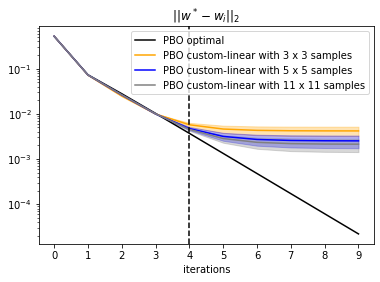

In [174]:
import matplotlib.pyplot as plt 

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)

plt.plot(iterations_validation, pbo_optimal_w_mean, label="PBO optimal", color="black")

for idx_n_samples, n_samples_ in enumerate(n_samples_list):
    plt.plot(iterations_validation, pbo_custom_linear_w_mean_n_samples[idx_n_samples], label=f"PBO custom-linear with {int(np.sqrt(n_samples_))} x {int(np.sqrt(n_samples_))} samples", color=n_samples_colors[idx_n_samples])
    plt.fill_between(iterations_validation, pbo_custom_linear_w_confidence_interval_n_samples[idx_n_samples, 0], pbo_custom_linear_w_confidence_interval_n_samples[idx_n_samples, 1], color=n_samples_colors[idx_n_samples], alpha=0.3)

plt.axvline(max_bellman_iterations, color="black", linestyle="--")
plt.xticks(iterations_validation)
plt.xlabel("iterations")
plt.yscale("log")
plt.title(r"$|| w^* - w_i ||_2$")
plt.legend()
_ = plt.savefig(f"figures/n_samples_distance_to_optimal_W_{max_bellman_iterations}.jpg", bbox_inches='tight')

### Distance to optimal value function

In [175]:
pbo_custom_linear_pi_mean_n_samples = np.zeros((len(n_samples_list), max_bellman_iterations_validation + 1))
pbo_custom_linear_pi_confidence_interval_n_samples = np.zeros((len(n_samples_list), 2, max_bellman_iterations_validation + 1))

for idx_n_samples in range(len(n_samples_list)):
    pbo_custom_linear_pi_mean_n_samples[idx_n_samples] = np.abs(pbo_custom_linear_pi_n_samples[idx_n_samples] - optimal_pi).mean(axis=0)
    pbo_custom_linear_pi_std_n_samples = np.abs(pbo_custom_linear_pi_n_samples[idx_n_samples] - optimal_pi).std(axis=0)
    pbo_custom_linear_pi_confidence_interval_n_samples[idx_n_samples] = confidence_interval(pbo_custom_linear_pi_mean_n_samples[idx_n_samples], pbo_custom_linear_pi_std_n_samples, n_seeds)

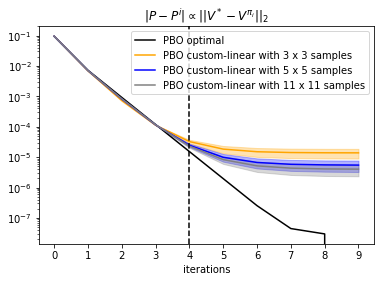

In [176]:
import matplotlib.pyplot as plt 

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)

plt.plot(iterations_validation, pbo_optimal_pi_mean, label="PBO optimal", color="black")

for idx_n_samples, n_samples_ in enumerate(n_samples_list):
    plt.plot(iterations_validation, pbo_custom_linear_pi_mean_n_samples[idx_n_samples], label=f"PBO custom-linear with {int(np.sqrt(n_samples_))} x {int(np.sqrt(n_samples_))} samples", color=n_samples_colors[idx_n_samples])
    plt.fill_between(iterations_validation, pbo_custom_linear_pi_confidence_interval_n_samples[idx_n_samples, 0], pbo_custom_linear_pi_confidence_interval_n_samples[idx_n_samples, 1], color=n_samples_colors[idx_n_samples], alpha=0.3)

plt.axvline(max_bellman_iterations, color="black", linestyle="--")
plt.xticks(iterations_validation)
plt.xlabel("iterations")
plt.yscale("log")
plt.title(r"$|P - P^i| \propto || V^* - V^{\pi_i} ||_2$")
plt.legend()
_ = plt.savefig(f"figures/n_samples_distance_to_optimal_Pi_{max_bellman_iterations}.jpg", bbox_inches='tight')

## Investigation on the initial std

In [177]:
n_initial_std_list = [1, 0.5, 0.0005]
n_initial_std_colors = ["orange", "blue", "green"]

### Extract data

In [178]:
pbo_linear_w_n_initial_std = np.zeros((len(n_initial_std_list), n_seeds, max_bellman_iterations_validation + 2, q_weights_dimension))
pbo_linear_pi_n_initial_std = np.zeros((len(n_initial_std_list), n_seeds, max_bellman_iterations_validation + 2))

for idx_n_initial_std, n_initial_std_ in enumerate(n_initial_std_list):
    for idx_seed, seed in enumerate(range(1, n_seeds + 1)):
        pbo_linear_w_n_initial_std[idx_n_initial_std, idx_seed] = np.load(f"figures/data/PBO_linear/{max_bellman_iterations}_W_{n_initial_std_}_{seed}.npy")
        pbo_linear_pi_n_initial_std[idx_n_initial_std, idx_seed] = np.load(f"figures/data/PBO_linear/{max_bellman_iterations}_Pi_{n_initial_std_}_{seed}.npy")

### Distances with the optimal weights

In [179]:
pbo_linear_w_mean_n_initial_std = np.zeros((len(n_initial_std_list), max_bellman_iterations_validation + 2))
pbo_linear_w_confidence_interval_n_initial_std = np.zeros((len(n_initial_std_list), 2, max_bellman_iterations_validation + 2))

for idx_n_initial_std in range(len(n_initial_std_list)):
    pbo_linear_w_mean_n_initial_std[idx_n_initial_std] = np.sqrt(np.mean(np.square(pbo_linear_w_n_initial_std[idx_n_initial_std] - optimal_w), axis=2)).mean(axis=0)
    pbo_linear_w_std_n_initial_std = np.sqrt(np.mean(np.square(pbo_linear_w_n_initial_std[idx_n_initial_std] - optimal_w), axis=2)).std(axis=0)
    pbo_linear_w_confidence_interval_n_initial_std[idx_n_initial_std] = confidence_interval(pbo_linear_w_mean_n_initial_std[idx_n_initial_std], pbo_linear_w_std_n_initial_std, n_seeds)

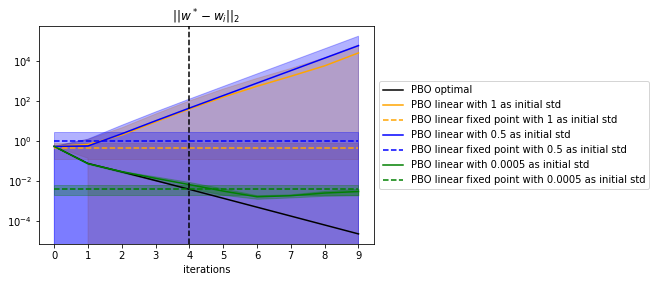

In [180]:
import matplotlib.pyplot as plt 

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)

plt.plot(iterations_validation, pbo_optimal_w_mean, label="PBO optimal", color="black")

for idx_n_initial_std, n_initial_std_ in enumerate(n_initial_std_list):
    plt.plot(iterations_validation, pbo_linear_w_mean_n_initial_std[idx_n_initial_std, :-1], label=f"PBO linear with {n_initial_std_} as initial std", color=n_initial_std_colors[idx_n_initial_std])
    plt.fill_between(iterations_validation, pbo_linear_w_confidence_interval_n_initial_std[idx_n_initial_std, 0, :-1], pbo_linear_w_confidence_interval_n_initial_std[idx_n_initial_std, 1, :-1], color=n_initial_std_colors[idx_n_initial_std], alpha=0.3)

    plt.hlines(pbo_linear_w_mean_n_initial_std[idx_n_initial_std, -1], 0, max_bellman_iterations_validation, color=n_initial_std_colors[idx_n_initial_std], linestyle="--", label=f"PBO linear fixed point with {n_initial_std_} as initial std")
    plt.fill_between(iterations_validation, pbo_linear_w_confidence_interval_n_initial_std[idx_n_initial_std, 0, -1], pbo_linear_w_confidence_interval_n_initial_std[idx_n_initial_std, 1, -1], color=n_initial_std_colors[idx_n_initial_std], alpha=0.3)

plt.axvline(max_bellman_iterations, color="black", linestyle="--")
plt.xticks(iterations_validation)
plt.xlabel("iterations")
plt.yscale("log")
plt.title(r"$|| w^* - w_i ||_2$")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
_ = plt.savefig(f"figures/n_initial_std_distance_to_optimal_W_{max_bellman_iterations}.jpg", bbox_inches='tight')

### Distance to optimal value function

In [181]:
pbo_linear_pi_mean_n_initial_std = np.zeros((len(n_initial_std_list), max_bellman_iterations_validation + 2))
pbo_linear_pi_confidence_interval_n_initial_std = np.zeros((len(n_initial_std_list), 2, max_bellman_iterations_validation + 2))

for idx_n_initial_std in range(len(n_initial_std_list)):
    pbo_linear_pi_mean_n_initial_std[idx_n_initial_std] = np.abs(pbo_linear_pi_n_initial_std[idx_n_initial_std] - optimal_pi).mean(axis=0)
    pbo_linear_pi_std_n_initial_std = np.abs(pbo_linear_pi_n_initial_std[idx_n_initial_std] - optimal_pi).std(axis=0)
    pbo_linear_pi_confidence_interval_n_initial_std[idx_n_initial_std] = confidence_interval(pbo_linear_pi_mean_n_initial_std[idx_n_initial_std], pbo_linear_pi_std_n_initial_std, n_seeds)

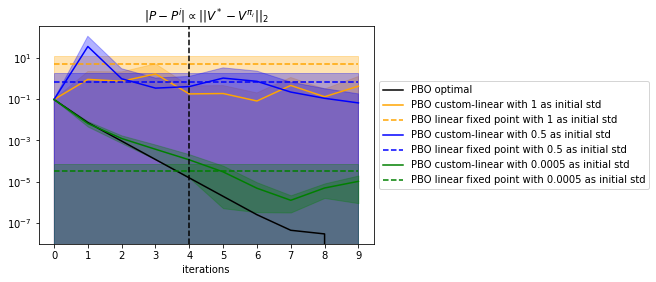

In [182]:
import matplotlib.pyplot as plt 

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)

plt.plot(iterations_validation, pbo_optimal_pi_mean, label="PBO optimal", color="black")

for idx_n_initial_std, n_initial_std_ in enumerate(n_initial_std_list):
    plt.plot(iterations_validation, pbo_linear_pi_mean_n_initial_std[idx_n_initial_std, :-1], label=f"PBO custom-linear with {n_initial_std_} as initial std", color=n_initial_std_colors[idx_n_initial_std])
    plt.fill_between(iterations_validation, pbo_linear_pi_confidence_interval_n_initial_std[idx_n_initial_std, 0, :-1], pbo_linear_pi_confidence_interval_n_initial_std[idx_n_initial_std, 1, :-1], color=n_initial_std_colors[idx_n_initial_std], alpha=0.3)
    
    plt.hlines(pbo_linear_pi_mean_n_initial_std[idx_n_initial_std, -1], 0, max_bellman_iterations_validation, color=n_initial_std_colors[idx_n_initial_std], linestyle="--", label=f"PBO linear fixed point with {n_initial_std_} as initial std")
    plt.fill_between(iterations_validation, pbo_linear_pi_confidence_interval_n_initial_std[idx_n_initial_std, 0, -1], pbo_linear_pi_confidence_interval_n_initial_std[idx_n_initial_std, 1, -1], color=n_initial_std_colors[idx_n_initial_std], alpha=0.3)

plt.axvline(max_bellman_iterations, color="black", linestyle="--")
plt.xticks(iterations_validation)
plt.xlabel("iterations")
plt.yscale("log")
plt.title(r"$|P - P^i| \propto || V^* - V^{\pi_i} ||_2$")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
_ = plt.savefig(f"figures/n_initial_std_distance_to_optimal_Pi_{max_bellman_iterations}.jpg", bbox_inches='tight')